# Overview

Here we present the results using our standard training regiment, which looks like:

```python
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
```

# Imports and other necessary functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

In [2]:
torch.cuda.set_device(2)

In [3]:
PATH = os.path.abspath('..')

In [4]:
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Training [O/H] 50th percentile with $gri$ images only using single regiment

In [5]:
train_label_csv = f'{PATH}/catalogs/train-oh_p50.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

val_idxs = get_cv_idxs(n)

In [6]:
def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

In [7]:
# train-val permutation
all_idxs = np.random.permutation(range(n))

# params
sz = 128
bs = 128
arch = resnet34

epoch      trn_loss   val_loss                                 
    0      0.165427   0.186054  
    1      0.159281   0.13543                                  



epoch      trn_loss   val_loss                                 
    0      0.13631    0.125786  



epoch      trn_loss   val_loss                                  
    0      0.092925   0.087836  
    1      0.106972   0.095564                                 
    2      0.091273   0.086135                                  
    3      0.118223   0.091112                                 
    4      0.103651   0.117282                                  
    5      0.093439   0.08877                                   
    6      0.088848   0.084301                                  



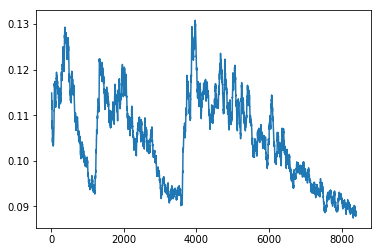

In [8]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse
    
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

This took ~30 minutes

In [82]:
learn.save(f'resnet34-single_sz{sz}-bs{bs}')

# Evaluate predictions

## Test set with TTA

In [9]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

In [16]:
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)

df_test = pd.read_csv(f'{PATH}/catalogs/test-oh_p50.csv', index_col=0)
y_test = df_test.loc[test_names].values

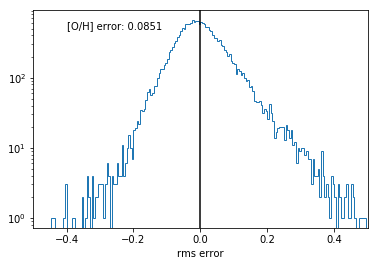

In [79]:
rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

plt.hist(p_test[:,0]-y_test[:,0], bins=200, histtype='step', range=[-0.5, 0.5]);
plt.text(-0.4, 500, f'[O/H] error: {rms_errors:.4f}')
plt.xlim(-0.5, 0.5)
plt.axvline(0, c='k')
plt.yscale('log')
plt.xlabel('rms error');

## Plot binned predictions

In [44]:
y_bins = np.linspace(8.3, 9.2, 10)
p_means = [np.mean(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]
p_stds = [np.std(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]

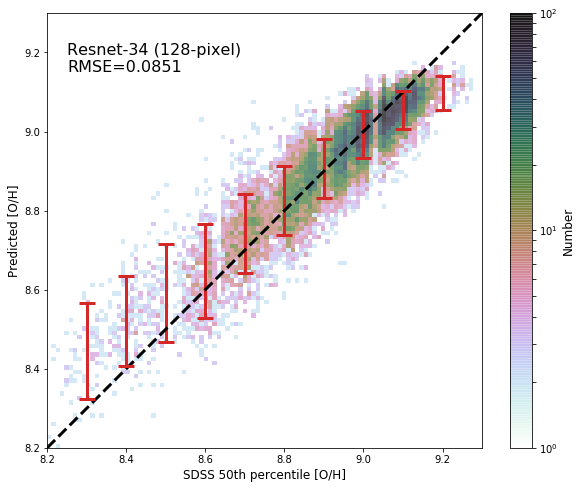

In [85]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
*_, im = ax.hist2d(y_test[:, 0], p_test[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=0.7)
ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
ax.set_aspect(aspect='equal')

# bins
ax.errorbar(y_bins, p_means, yerr=p_stds, c='C3', ls='', lw=3, capsize=8, capthick=3)

ax.text(8.25, 9.15, f'Resnet-34 ({sz}-pixel) \n' f'RMSE={rms_errors:.4f}', fontsize=16)

ax.set_xlabel('SDSS 50th percentile [O/H]', fontsize=12)
ax.set_ylabel('Predicted [O/H]', fontsize=12)
cb = fig.colorbar(im);
cb.set_label('Number', fontsize=12)

fig.savefig(f'{PATH}/results/single-sz{sz}_pred-vs-SDSS.pdf')

# Half-size $gri$ image training

In [96]:
sz = 64
bs = 128
arch = resnet34

epoch      trn_loss   val_loss                                 
    0      0.161126   0.1531    
    1      0.153842   0.143275                                 



epoch      trn_loss   val_loss                                 
    0      0.11655    0.106537  



epoch      trn_loss   val_loss                                  
    0      0.095594   0.089043  
    1      0.104203   0.094765                                 
    2      0.094517   0.087593                                  
    3      0.115206   0.108712                                 
    4      0.101441   0.109078                                  
    5      0.094933   0.09261                                   
    6      0.091388   0.088803                                  



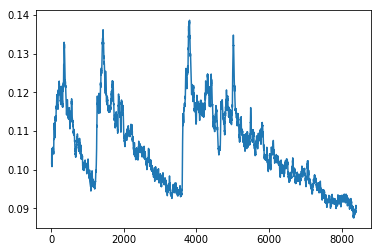

In [97]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse
    
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [98]:
learn.save(f'resnet34-single_sz{sz}-bs{bs}')

This took ~20 minutes

In [99]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

In [100]:
y_bins = np.linspace(8.3, 9.2, 10)
p_means = [np.mean(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]
p_stds = [np.std(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]

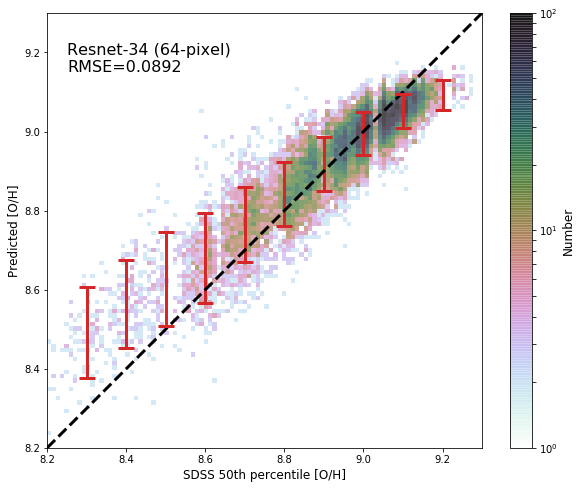

In [101]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
*_, im = ax.hist2d(y_test[:, 0], p_test[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=0.7)
ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
ax.set_aspect(aspect='equal')

# bins
ax.errorbar(y_bins, p_means, yerr=p_stds, c='C3', ls='', lw=3, capsize=8, capthick=3)

ax.text(8.25, 9.15, f'Resnet-34 ({sz}-pixel) \n' f'RMSE={rms_errors:.4f}', fontsize=16)

ax.set_xlabel('SDSS 50th percentile [O/H]', fontsize=12)
ax.set_ylabel('Predicted [O/H]', fontsize=12)
cb = fig.colorbar(im);
cb.set_label('Number', fontsize=12)

fig.savefig(f'{PATH}/results/single-sz{sz}_pred-vs-SDSS.pdf')

# Quarter size $gri$ imaging

In [90]:
sz = 32
bs = 128
arch = resnet34

epoch      trn_loss   val_loss                                 
    0      0.156711   0.141361  
    1      0.145207   0.133021                                 



epoch      trn_loss   val_loss                                 
    0      0.130549   0.12617   



epoch      trn_loss   val_loss                                 
    0      0.101018   0.096751  
    1      0.110522   0.105073                                 
    2      0.099392   0.094615                                  
    3      0.126136   0.109628                                 
    4      0.108735   0.103027                                 
    5      0.100205   0.092346                                  
    6      0.099108   0.091998                                  



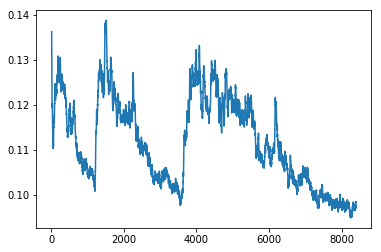

In [91]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse
    
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [92]:
learn.save(f'resnet34-single_sz{sz}-bs{bs}')

And that took ~15 minutes

In [93]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

In [94]:
y_bins = np.linspace(8.3, 9.2, 10)
p_means = [np.mean(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]
p_stds = [np.std(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]

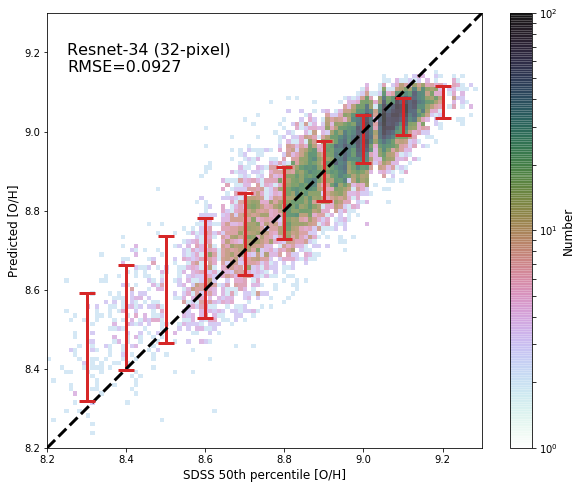

In [95]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
*_, im = ax.hist2d(y_test[:, 0], p_test[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=0.7)
ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
ax.set_aspect(aspect='equal')

# bins
ax.errorbar(y_bins, p_means, yerr=p_stds, c='C3', ls='', lw=3, capsize=8, capthick=3)

ax.text(8.25, 9.15, f'Resnet-34 ({sz}-pixel) \n' f'RMSE={rms_errors:.4f}', fontsize=16)

ax.set_xlabel('SDSS 50th percentile [O/H]', fontsize=12)
ax.set_ylabel('Predicted [O/H]', fontsize=12)
cb = fig.colorbar(im);
cb.set_label('Number', fontsize=12)

fig.savefig(f'{PATH}/results/single-sz{sz}_pred-vs-SDSS.pdf')